In [346]:
import os
from random import choice, seed
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
from collections import Counter

# seed(42)
folder_name = "data/input/scripts_imsdb"
screenplay_name = choice(os.listdir(folder_name))

In [347]:
with open(os.path.join(folder_name, screenplay_name)) as f : 
    screenplay = f.read()
lines = screenplay.split("\n")

In [348]:
EMPTY_LINE_LABEL = "E"
SCENES_BOUNDARY_AND_DESCRIPTION_LABEL = "SN"
SCENES_BOUNDARY_LABEL = "S"
SCENES_DESCRIPTION_LABEL = "N"
CHARACTER_LABEL = "C"
DIALOGUE_LABEL = "D"
METADATA_LABEL = "M"

In [349]:
CHARACTER_KEYWORDS = ["(O.S.)","(CONT'D)", "(0.S.)", "(O. S.)", "(0. S.)", "(V.O.)"]
BEGINNING_SCENES_KEYWORDS = ["EXT ", "EXT.", "INT ", "INT."]
ENDING_SCENES_KEYWORDS = ["FADE IN", "FADE INTO", "CUT TO", "DISSOLVE TO"]
META_KEYWORDS = ["(", ")"]
DIALOGUE_KEYWORDS = ["?"]

def get_indent_histogram(lines):
    indents = []
    for line in lines:
        len_line_with_no_left_spaces = len(line.lstrip())
        if len_line_with_no_left_spaces == 0 :  # the line only had spaces
            indents.append(-1)
        else : 
            indents.append(len(line) - len_line_with_no_left_spaces)
    return indents

def find_scenes(lines, beginning_scenes_keywords = BEGINNING_SCENES_KEYWORDS, end_scenes_keywords = ENDING_SCENES_KEYWORDS): 
    scenes = []
    current_scene = []
    for line in lines : 
        has_keyword = False
        for keyword in beginning_scenes_keywords + end_scenes_keywords : 
            if keyword in line : 
                if keyword in beginning_scenes_keywords : 
                    scenes.append(current_scene)
                    current_scene = [line]
                    has_keyword = True
                    break
                elif keyword in end_scenes_keywords : 
                    current_scene.append(line)
                    scenes.append(current_scene)
                    current_scene = []
                    has_keyword = True
                    break
        if not has_keyword : 
            current_scene.append(line)
    scenes.append(current_scene)
    return clean_scenes(scenes)

def clean_scenes(scenes):
    cleaned_scenes = []
    for scene in scenes : 
        if len(''.join(scene)) > 0 : 
            cleaned_scenes.append(scene)
    return cleaned_scenes

def occurences_keywords_in_groups(groups, keywords):
    groups_keyword_quantity = [0 for _ in range(len(groups))]
    for i, group in enumerate(groups) : 
        group_text = ''.join(group)
        for keyword in keywords:
            groups_keyword_quantity[i] += group_text.count(keyword)
    return groups_keyword_quantity

def frequency_capitalized_in_groups(groups):
    groups_upper_quantity = [0 for _ in range(len(groups))]
    for i, group in enumerate(groups) : 
        group_text = ''.join(group)
        total_letters = sum((letter.isupper() or letter.islower()) for letter in group_text)
        if total_letters != 0 : 
            groups_upper_quantity[i] += round(sum(letter.isupper() for letter in group_text)/total_letters, 2)
        else : 
            groups_upper_quantity[i] = 0
    return groups_upper_quantity

def mean_text_length_in_groups(groups):
    groups_text_length = []
    for i, group in enumerate(groups) : 
        groups_text_length.append(round(sum([len(line.lstrip()) for line in group])/len(group), 2))
    return groups_text_length

Counter({-1: 2161, 10: 1644, 0: 1503, 20: 648, 13: 254, 23: 165, 14: 120, 21: 61, 22: 50, 9: 40, 61: 34, 53: 27, 52: 26, 12: 25, 11: 23, 60: 21, 24: 21, 62: 16, 19: 14, 17: 12, 58: 11, 51: 10, 54: 10, 15: 9, 25: 9, 50: 9, 56: 9, 63: 9, 55: 9, 26: 9, 57: 9, 59: 8, 64: 8, 16: 4, 49: 3, 18: 2, 66: 2, 65: 2, 7: 1, 8: 1, 33: 1, 43: 1, 32: 1, 28: 1, 31: 1, 70: 1, 27: 1, 29: 1})
Confessions-of-a-Dangerous-Mind.txt


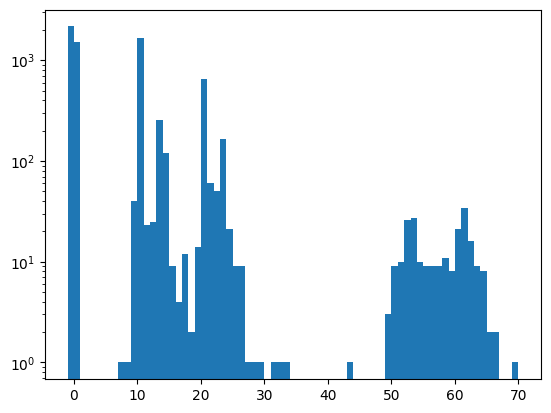

In [350]:
indents = get_indent_histogram(lines)
plt.hist(indents, bins = max(indents) + 1, log=True)

print(Counter(indents))
print(screenplay_name)

Found 217 scenes
Counter({-1: 1940, 10: 1525, 0: 1326, 20: 620, 13: 170, 23: 136, 14: 108, 21: 60, 22: 46, 9: 40, 61: 33, 53: 25, 52: 25, 11: 23, 60: 19, 12: 15, 19: 14, 24: 14, 62: 12, 58: 10, 54: 10, 26: 9, 56: 8, 51: 8, 63: 8, 55: 8, 50: 8, 59: 7, 17: 7, 57: 7, 64: 7, 15: 6, 25: 5, 49: 3, 66: 2, 16: 2, 65: 2, 18: 1, 32: 1, 28: 1, 31: 1, 70: 1, 27: 1})
Confessions-of-a-Dangerous-Mind.txt


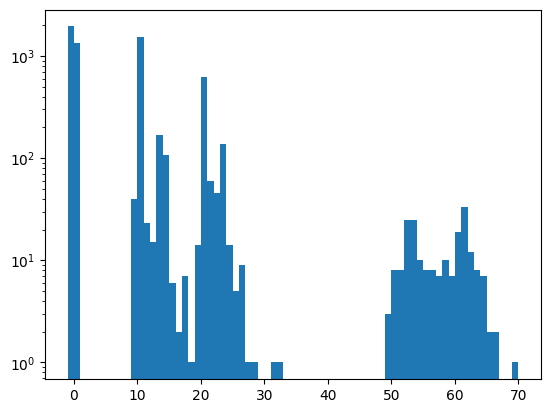

In [351]:
scenes = find_scenes(lines)
print(f"Found {len(scenes)} scenes")
if len(scenes) > 3 : 
    cutable = min(len(scenes)//2 -1, 10)
    middle_lines = sum([scene for scene in scenes[cutable:-cutable]], [])
else : 
    middle_lines = sum(scenes, [])
indents = get_indent_histogram(middle_lines)
plt.hist(indents, bins = max(indents) + 1, log=True)

print(Counter(indents))
print(screenplay_name)

In [372]:
def print_several_lists(list_labels, lists):
    maximum_length = max([max([len(str(element)) for element in sublist]) for sublist in lists])
    for i, sublist in enumerate(lists):
        string = f"{list_labels[i]} : ["
        for element in sublist : 
            string += " " * (maximum_length - len(str(element))) + str(element) + ", "
        string += "]"
        print(string)

def characterize_indent_levels(lines, indents):
    indents_counter = Counter(indents)
    relevant_indent_levels = []
    for indent_level in indents_counter : 
        if indents_counter[indent_level] > 10 : 
            relevant_indent_levels.append(indent_level)
    groups = []
    for indent_level in relevant_indent_levels : 
        lines_idxs = np.where(np.array(indents) ==indent_level)[0]
        group_lines = [lines[lines_idxs[i]] for i in range(len(lines_idxs))]
        groups.append(group_lines)
    
    mean_text_lengths = mean_text_length_in_groups(groups)
    capitalized_frequency = frequency_capitalized_in_groups(groups)
    characters_keywords_occurences = occurences_keywords_in_groups(groups, CHARACTER_KEYWORDS)
    scenes_beginning_keywords_occurences = occurences_keywords_in_groups(groups, BEGINNING_SCENES_KEYWORDS)
    scenes_ending_keywords_occurences = occurences_keywords_in_groups(groups, ENDING_SCENES_KEYWORDS)
    meta_keywords_occurences = occurences_keywords_in_groups(groups, META_KEYWORDS)
    dialogues_keywords_occurences = occurences_keywords_in_groups(groups, DIALOGUE_KEYWORDS)
    
    
    result = {}

    for i, group in enumerate(groups) : 
        if relevant_indent_levels[i] == -1 : 
            result[relevant_indent_levels[i]] = EMPTY_LINE_LABEL
        elif characters_keywords_occurences[i] > 0 :
            result[relevant_indent_levels[i]] = CHARACTER_LABEL
        elif scenes_beginning_keywords_occurences[i] > 0 : 
            result[relevant_indent_levels[i]] = SCENES_BOUNDARY_AND_DESCRIPTION_LABEL
        elif scenes_ending_keywords_occurences[i]/len(group) > 0.8 : 
            result[relevant_indent_levels[i]] = SCENES_BOUNDARY_LABEL
        elif capitalized_frequency[i] > 0.9 and mean_text_lengths[i] < 10 :
            result[relevant_indent_levels[i]] = CHARACTER_LABEL
        elif meta_keywords_occurences[i] / len(group) > 1.0 : # usually two parenthesis per line, one is the minimum
            result[relevant_indent_levels[i]] = METADATA_LABEL
        elif dialogues_keywords_occurences[i] > 0 : 
            result[relevant_indent_levels[i]] = DIALOGUE_LABEL
        else : 
            result[relevant_indent_levels[i]] = "?"
    
    all_lists = [
        relevant_indent_levels, 
        [len(group) for group in groups],
        characters_keywords_occurences,
        capitalized_frequency,
        mean_text_lengths,
        scenes_beginning_keywords_occurences,
        scenes_ending_keywords_occurences,
        meta_keywords_occurences,
        dialogues_keywords_occurences,
        result.values()
        ]
    print_several_lists(["I", "L", "C", "C", "L", "S", "S", "M", "D", "R"], all_lists)

In [373]:
characterize_indent_levels(middle_lines, indents)

I : [    0,    -1,    20,    10,    53,    61,    23,    52,    62,    13,    21,    14,    22,    60,    19,     9,    24,    11,    12, ]
L : [ 1326,  1940,   620,  1525,    25,    33,   136,    25,    12,   170,    60,   108,    46,    19,    14,    40,    14,    23,    15, ]
C : [    0,     0,    75,     0,     0,     0,    18,     0,     0,     0,     5,     0,     2,     0,     0,     0,     1,     0,     0, ]
C : [ 0.15,     0,   1.0,  0.06,   1.0,     0,   1.0,   1.0,     0,  0.07,   1.0,  0.01,   1.0,     0,  0.91,  0.07,   1.0,  0.08,  0.05, ]
L : [42.62,   0.0,  8.02, 28.58,  11.0,  3.03,  8.23, 11.16,   3.0, 27.98,  7.63, 13.72,  7.67,  3.11,  5.64, 30.25,  6.71, 30.43,  23.2, ]
S : [  196,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0, ]
S : [    0,     0,     0,     0,     0,     0,     0,     4,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0, ]
M : [   34,     0,  

In [379]:
lines_idxs = np.where(np.array(indents) ==12)[0]
print(len(lines_idxs))
for i in range(len(lines_idxs)):
    print(middle_lines[lines_idxs[i]])

15
            Well...
            Jesus, she's gotta pick this guy.   This
            is just too good.
            ... I'll ask her what she likes to do and
            --
            Ready one, take one.   Ready two, take
            two.
            And if she doesn't know what she likes to
            do --
            Ready three, take three. The only date
            he's ever had is with his right hand.
            ... then I'll know she hasn't done it
            yet.
            Excuse me, is this seat taken?
            By you.
